In [14]:
# adapted from: 
# https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

In [1]:
import numpy as np
from scipy import signal
from scipy.io import wavfile
from matplotlib import pyplot as plt
import seaborn as sns

ICA steps to convergence:
1. Center x by subtracting the mean
2. Whiten x
3. Choose a random initial value for the de-mixing matrix w
4. Calculate the new value for w
5. Normalize w
6. Check whether algorithm has converged (until W is orthogonal) and if it hasn’t, return to step 4
7. Take the dot product of w and x to get the independent source signals

In [2]:
# g(x) in this algorithm is tanh(x):
def g(x):
    return np.tanh(x)

In [3]:
# g'(x) is derivative of g(x) = tanh(x) 
def g_dash(x):
    return 1 - g(x) * g(x)

In [4]:
def center(x):
    x = np.array(x)
    mean = x.mean(axis=1, keepdims=True)
    return x - mean

# Whitening a signal:

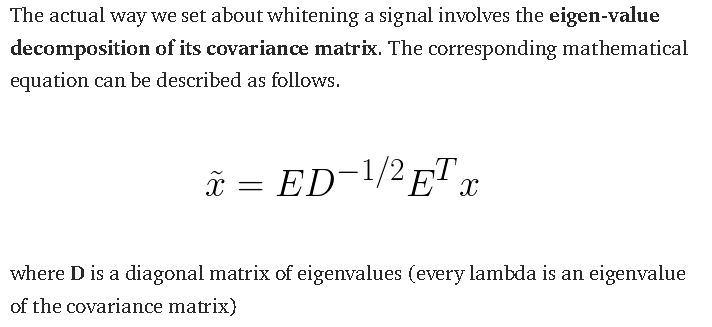

source: https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

In [5]:
# To “whiten” a given signal means that we transform it in such a way that 
# potential correlations between its components are removed (covariance equal to 0) 
# and the variance of each component is equal to 1.
def whitening(x):
    cov = np.cov(x)
    d, E = np.linalg.eigh(cov)
    D = np.diag(d)
    D_inv = np.sqrt(np.linalg.inv(D))
    x_whiten = np.dot(E, np.dot(D_inv, np.dot(E.T, x)))
    return x_whiten

# Mathematically:

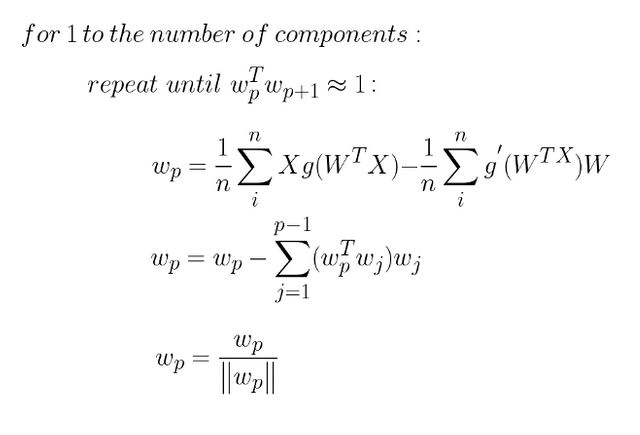

source: https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e

In [6]:
# according to algorithm given in first cell
def calculate_new_w(w, X):
    w_new = (X * g(np.dot(w.T, X))).mean(axis=1) - g_dash(np.dot(w.T, X)).mean() * w
    w_new /= np.sqrt((w_new ** 2).sum())
    return w_new

In [7]:
# entire algorithm
def ica(X, iterations, tolerance=1e-5):
    X = center(X)
    X = whitening(X)
    components_nr = X.shape[0]
    W = np.zeros((components_nr, components_nr), dtype=X.dtype)
    
    for i in range(components_nr):
        w = np.random.rand(components_nr)
        
        for j in range(iterations):
            w_new = calculate_new_w(w, X)
            
            if i >= 1:
                w_new -= np.dot(np.dot(w_new, W[:i].T), W[:i])
                
            distance = np.abs(np.abs((w * w_new).sum()) - 1)
            w = w_new
            
            if distance < tolerance:
                break
        W[i, :] = w
        
    S = np.dot(W, X)
    
    return S

In [8]:
def plot_mixture_sources_predictions(X, original_sources, S):
    fig = plt.figure()

    plt.subplot(3, 1, 1)
    for x in X:
        plt.plot(x)
    plt.title("mixtures")

    plt.subplot(3, 1, 2)
    for s in original_sources:
        plt.plot(s)
    plt.title("real sources")

    plt.subplot(3,1,3)
    for s in S:
        plt.plot(s)
    plt.title("predicted sources")
    
    fig.tight_layout()
    plt.show()

In [9]:
def mix_sources(mixtures, apply_noise=False):
    for i in range(len(mixtures)):
        max_val = np.max(mixtures[i])
        
        #if max_val > 1 or np.min(mixtures[i]) < 1:
        #    mixtures[i] = mixtures[i] / (max_val / 2) - 0.5
            
    X = np.c_[[mix for mix in mixtures]]

    if apply_noise:        
        X += 0.02 * np.random.normal(size=X.shape)
        
    return X

In [10]:
n_samples = 2000
time = np.linspace(0, 8, n_samples)
s1 = np.sin(2 * time)
s2 = np.sign(np.sin(3 * time)) # square signal
s3 = signal.sawtooth(2 * np.pi * time)

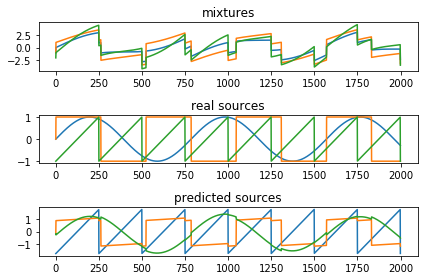

In [11]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=1000)
actual = mix_sources([s1,s2,s3])
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

# Change iterations and see the difference:

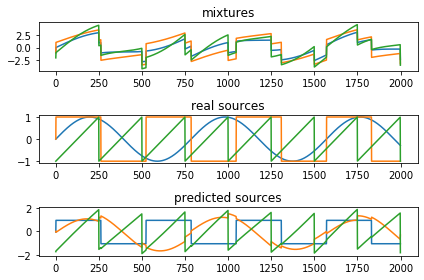

In [12]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=100)
actual = mix_sources([s1,s2,s3])
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

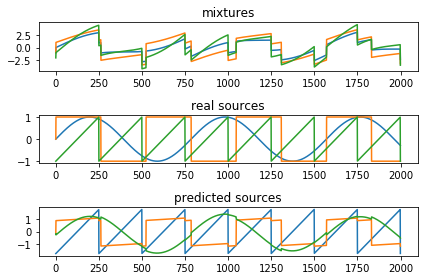

In [13]:
X = np.c_[s1, s2, s3]
A = np.array(([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]]))
X = np.dot(X, A.T)
X = X.T
S = ica(X, iterations=10)
actual = mix_sources([s1,s2,s3])
plot_mixture_sources_predictions(X, [s1, s2, s3], S)

# we see a difference here